In [14]:
import pandas as pd
from pathlib import Path 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import numpy as np
import sklearn
import statsmodels as sm
from sklearn.impute import SimpleImputer

In [4]:
pathfile=Path('/content/machine_temp_failure_missing.csv')
df1=pd.read_csv(pathfile)
df1[df1.isnull().any(axis=1)]

,timestamp,value
2054,10-12-2013 00:25,NaN
2055,10-12-2013 00:30,NaN
2056,10-12-2013 00:35,NaN
2057,10-12-2013 00:40,NaN
2058,10-12-2013 00:45,NaN
...,...,...
22685,19-02-2014 14:40,NaN
22686,19-02-2014 14:45,NaN
22687,19-02-2014 14:50,NaN
22688,19-02-2014 14:55,NaN


In [5]:
Statistics= df1.describe()
print(Statistics)
df1.rename(columns={"value": "temperature"}, inplace=True)


              value
count  21410.000000
mean      85.968188
std       13.553070
min        2.084721
25%       83.082867
50%       89.251290
75%       93.910748
max      108.510543


In [6]:
df1['delta_temperature'] = df1['temperature'].diff().shift(-1)
print(df1.tail())

              timestamp  temperature  delta_temperature
22690  19-02-2014 15:05    98.185415          -0.381246
22691  19-02-2014 15:10    97.804168          -0.668700
22692  19-02-2014 15:15    97.135468           0.921384
22693  19-02-2014 15:20    98.056852          -1.152991
22694  19-02-2014 15:25    96.903861                NaN


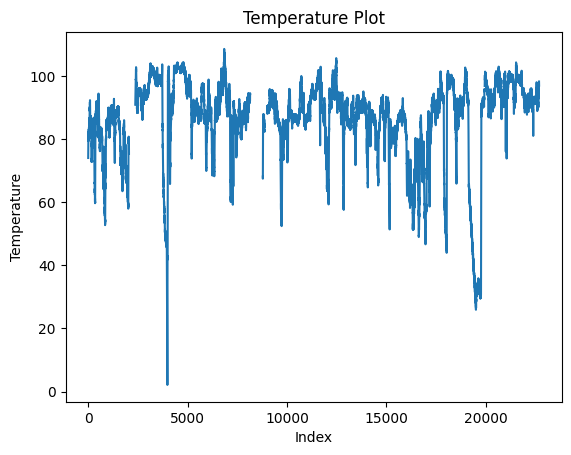

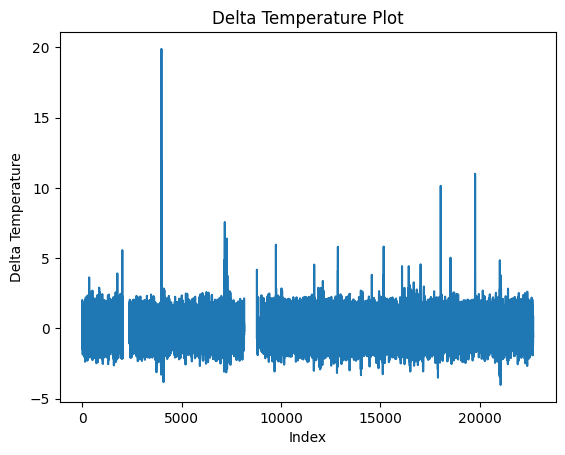

In [7]:
plt.plot(df1.index, df1['temperature'])
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.title('Temperature Plot')
plt.show()

plt.plot(df1.index, df1['delta_temperature'])
plt.xlabel('Index')
plt.ylabel('Delta Temperature')
plt.title('Delta Temperature Plot')
plt.show()

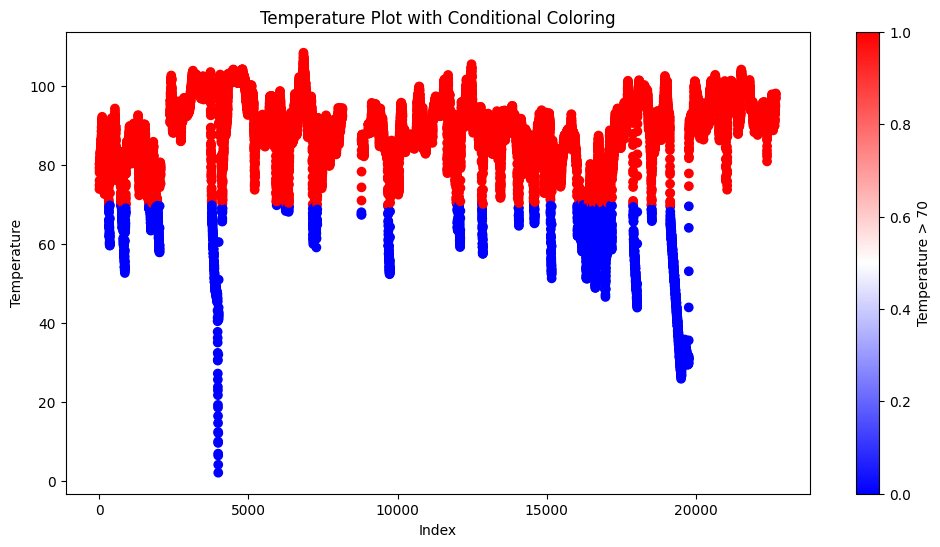

In [8]:
plt.figure(figsize=(12, 6))
plt.scatter(df1.index, df1['temperature'], c=df1['temperature'] > 70, cmap='bwr')
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.title('Temperature Plot with Conditional Coloring')
plt.colorbar(label='Temperature > 70')
plt.show()

In [9]:
def read_dataset(folder, file, date_col=None):
    df = pd.read_csv(folder / file, 
                     index_col=date_col, 
                     parse_dates=[date_col])
    return df



def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):  
    df_missing = df2.rename(columns={col: 'missing'})
    
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    subplots_size = len(columns)

    fig, ax = plt.subplots(subplots_size+1, 1, sharex=True)
    plt.subplots_adjust(hspace=0.25)
    fig.suptitle = title 
    
    df1[col].plot(ax=ax[0], figsize=(10, 16))
    ax[0].set_title('Original Dataset')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)    
    
    for i, colname in enumerate(columns):
        df_missing[colname].plot(ax=ax[i+1])
        ax[i+1].set_title(colname)

    plt.show()


def rmse_score(df1, df2, col=None):
    df_missing = df2.rename(columns={col: 'missing'})
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    scores = []
    for comp_col in columns[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_missing[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE for {comp_col}: {rmse}')
    return scores

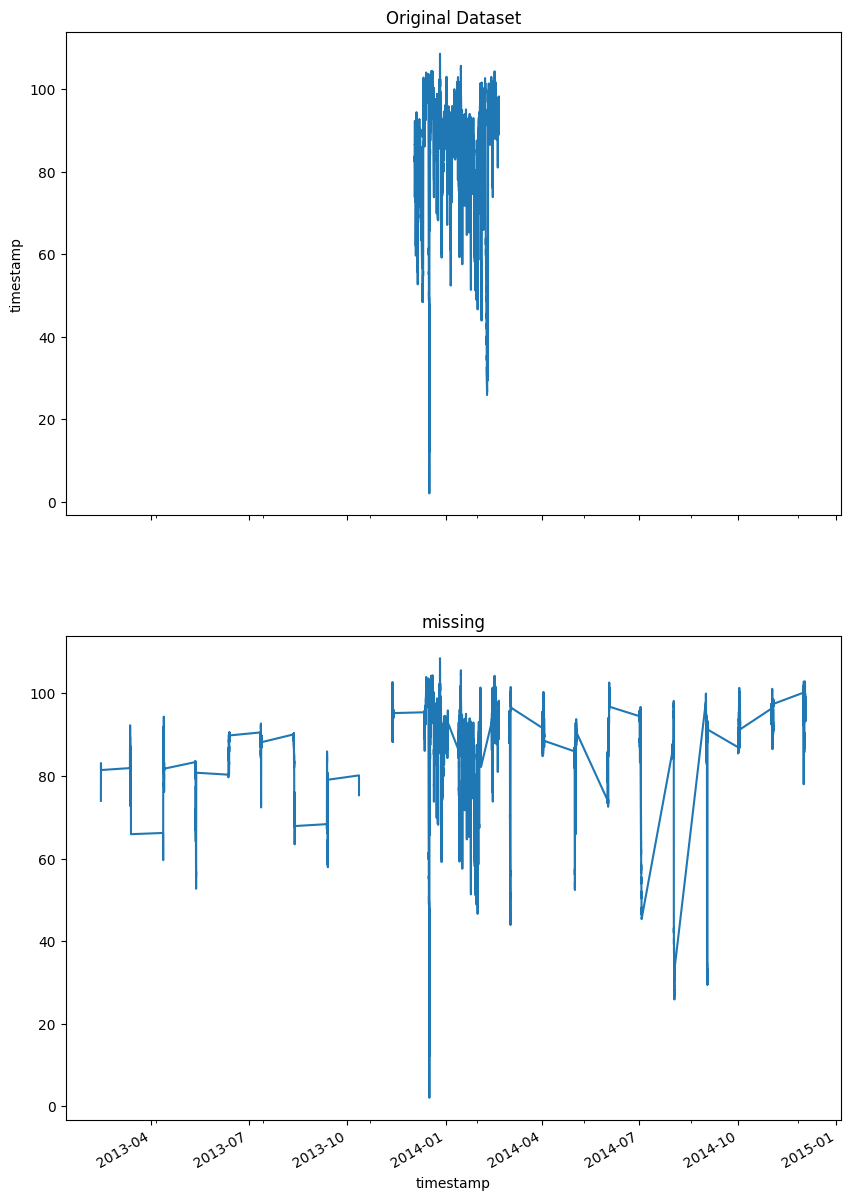

In [10]:
pathfile1=Path('/content/Data')
df2= read_dataset(pathfile1, 'machine_temp_failure_missing.csv', 'timestamp' )
df1= read_dataset(pathfile1, 'machine_temp_failure_original.csv', 'timestamp' )
plot_dfs(df1, df2, 'value', 'Temperature', 'value', 'timestamp')


In [11]:
df2_imp_p=df2.copy()
df2_imp_p['ffill'] = df2_imp_p['value'].fillna(method='ffill')
df2_imp_p['bfill'] = df2_imp_p['value'].fillna(method='bfill')
df2_imp_p['mean'] = df2_imp_p['value'].fillna(df2_imp_p['value'].mean())

In [12]:
_= rmse_score(df1, df2_imp_p, 'value')

RMSE for ffill: 1.4666115658526897
RMSE for bfill: 5.538329974927272
RMSE for mean: 2.6118121108260417


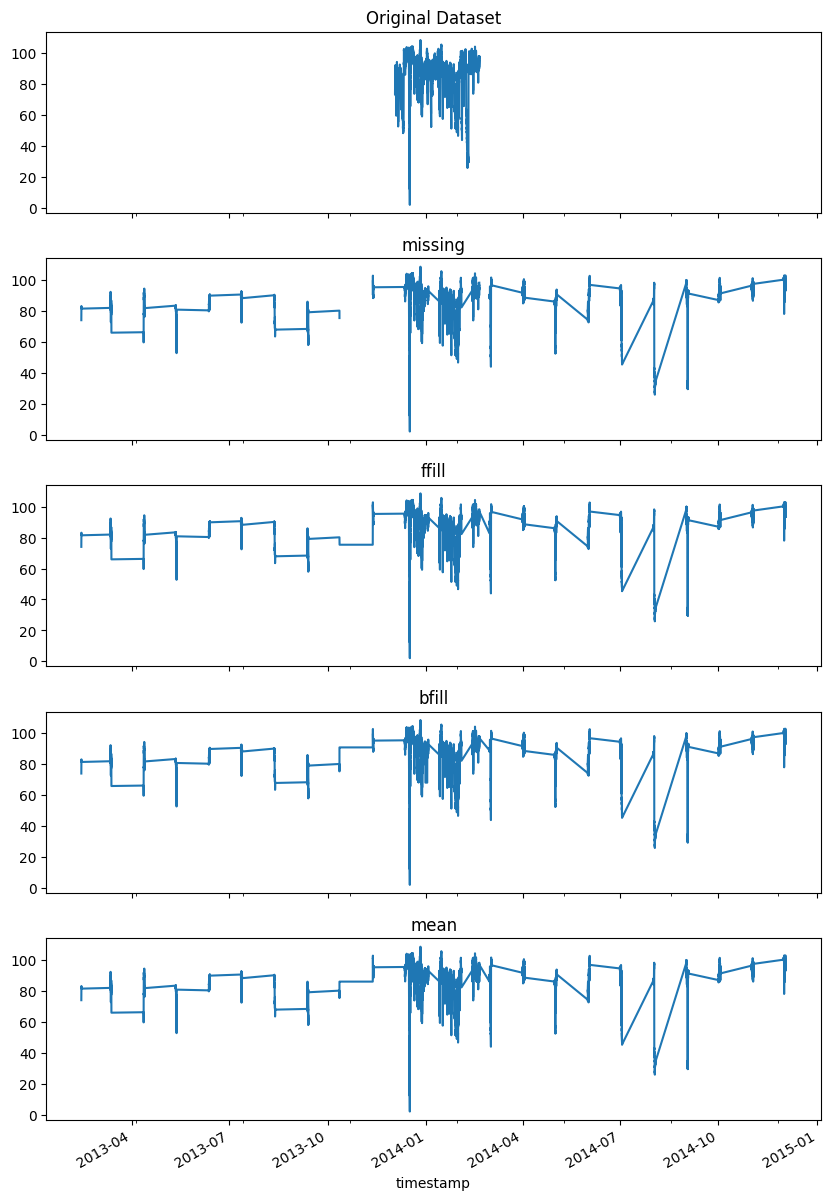

In [15]:
plot_dfs(df1, df2_imp_p, 'value')

In [19]:
strategy = [
    ('Mean Strategy', 'mean'),
    ('Median Strategy', 'median'),
    ('Most Frequent Strategy', 'most_frequent')]



df2_imp_s=df2.copy()
df2_imp_s_vals = df2_imp_s['value'].values.reshape(-1,1)

for s_name, s in strategy:
    df2_imp_s[s_name] = (
        SimpleImputer(strategy=s).fit_transform(df2_imp_s_vals))

In [20]:
df2_imp_s.head()

,value,Mean Strategy,Median Strategy,Most Frequent Strategy
timestamp,,,,
2013-02-12 21:15:00,73.967322,73.967322,73.967322,73.967322
2013-02-12 21:20:00,74.935882,74.935882,74.935882,74.935882
2013-02-12 21:25:00,76.124162,76.124162,76.124162,76.124162
2013-02-12 21:30:00,78.140707,78.140707,78.140707,78.140707
2013-02-12 21:35:00,79.329836,79.329836,79.329836,79.329836


In [22]:
x=rmse_score(df1, df2_imp_s, 'value')
print(x)

RMSE for Mean Strategy: 2.6118121108260417
RMSE for Median Strategy: 2.0176725629240635
RMSE for Most Frequent Strategy: 22.936820075564288
[2.6118121108260417, 2.0176725629240635, 22.936820075564288]


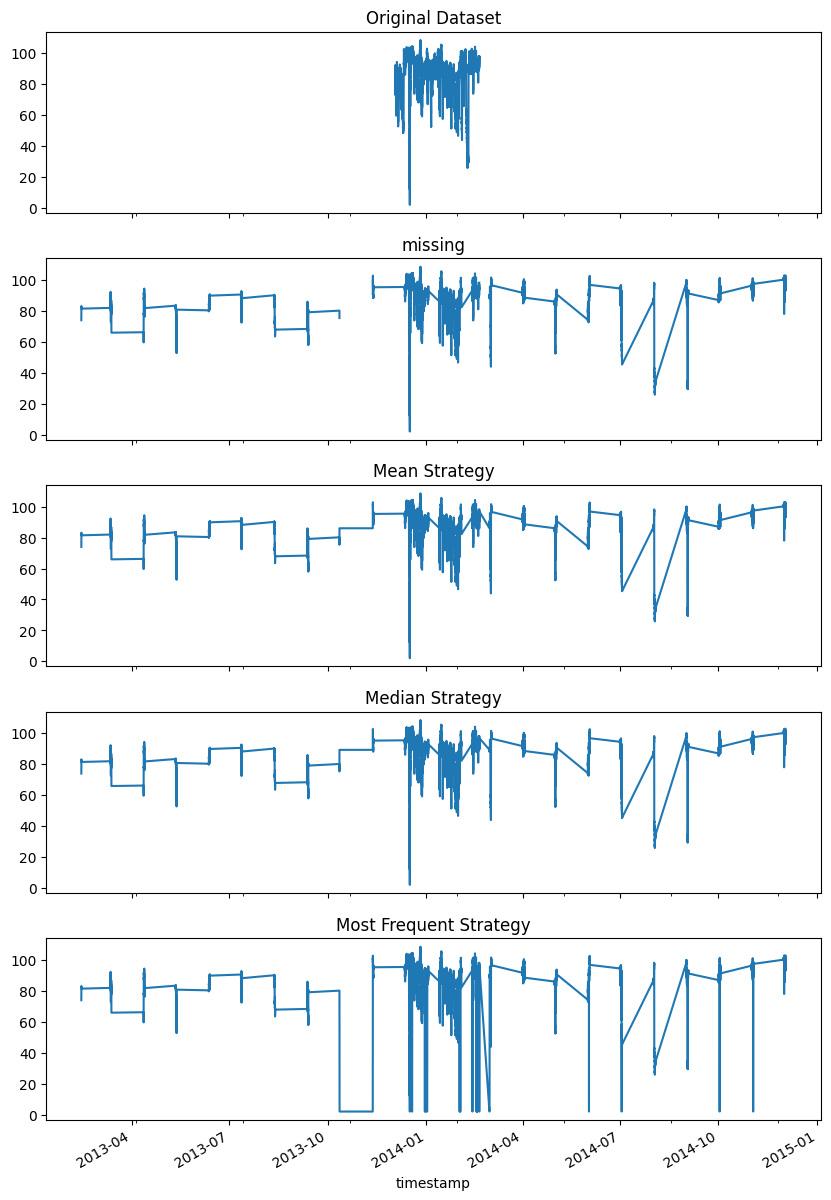

In [23]:
plot_dfs(df1, df2_imp_s, 'value')

In [24]:
df2_int=df2.copy()
df2_int.interpolate()

,value
timestamp,
2013-02-12 21:15:00,73.967322
2013-02-12 21:20:00,74.935882
2013-02-12 21:25:00,76.124162
2013-02-12 21:30:00,78.140707
2013-02-12 21:35:00,79.329836
...,...
2014-02-19 15:05:00,98.185415
2014-02-19 15:10:00,97.804168
2014-02-19 15:15:00,97.135468


In [25]:
interpolations = [
    'linear',
    'quadratic',
    'nearest',
    'cubic'
]

for intp in interpolations:
    df2_int[intp] = df2_int['value'].interpolate(method=intp)

df2_int['spline'] = \
        df2_int['value'].interpolate(method='spline', order=3)

df2_int['polynomial'] = \
        df2_int['value'].interpolate(method='polynomial',order=3)

ValueError: ignored